In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pylab
import os
from datetime import datetime

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from efficientnet_keras_transfer_learning import EfficientNetB1 as efficient_net

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

In [5]:
df_shoes = pd.read_csv('post_analysis_shoes.csv')
df_shoes.shape

(8064, 18)

In [6]:
def plot_value_counts(df,column,kind,rotation=None):
    if(kind == 'barh'):
        plt.figure(figsize=(10,25))
    else:
        plt.figure(figsize=(16,5))
    (df[column].value_counts()/len(df)).plot(kind=kind,title=f"{column}")
    if(rotation):
        plt.xticks(rotation=rotation)
    plt.show()

In [7]:
popular_brands = ['olympikus', 'under_armour', 'nike', 'adidas', 'mizuno','asics','puma','fila']

df_shoes = df_shoes[df_shoes['brand'].isin(popular_brands)]

['olympikus', 'nike', 'adidas', 'asics', 'puma', 'mizuno', 'fila']


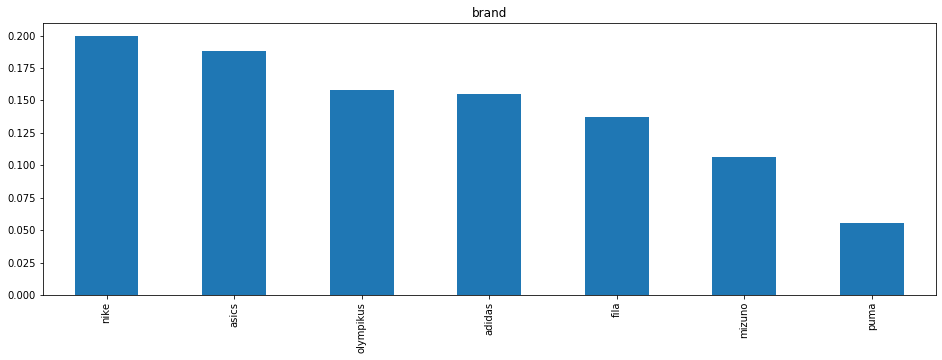

In [8]:
print(list(df_shoes['brand'].unique()))
    
plot_value_counts(df_shoes,'brand','bar')

# Preprocessing Functions

In [9]:
def plot_images(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [10]:
base_path = '/home/raphael/Documents/Projects/netshoes_ml_project/netshoes/images/'
train_image_generator = ImageDataGenerator(rescale=1./255,
                                            rotation_range=45,
                                            width_shift_range=.15,
                                            height_shift_range=.15,
                                            horizontal_flip=True,
                                            zoom_range=0.5)

validation_image_generator = ImageDataGenerator(rescale=1./255)

In [15]:
IMG_SHAPE = (240,240)
epochs = 100
drop_rate = 0.25

checkpoint_path = './brand_model/drop25_lr0003_graph_b1'

if(not os.path.exists(checkpoint_path)):
    os.makedirs(checkpoint_path)
    
    base_model = efficient_net(weights="imagenet", include_top=False,
        input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], 3))
    base_model.trainable = False
    
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        Dropout(drop_rate),
        tf.keras.layers.Dense(df_shoes['brand'].nunique())
    ])
    
    initial_epoch = 0
else:
    model = tf.keras.models.load_model(checkpoint_path)
    initial_epoch = epochs

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b1 (Model)      (None, 8, 8, 1280)        6575232   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 8967      
Total params: 6,584,199
Trainable params: 8,967
Non-trainable params: 6,575,232
_________________________________________________________________


In [16]:
df_shoes['images'] = df_shoes['images'].str.split(',')
df_data = df_shoes.explode('images')[['images','brand']]
df_data['images'] = base_path + df_data['images']
df_data.shape

(17495, 2)

In [17]:
batch_size = 128

train, valid_test = train_test_split(df_data,
                                test_size=0.15,
                                stratify=df_data['brand'].values,
                                random_state=42)

valid, test = train_test_split(valid_test,
                                test_size=0.25,
                                stratify=valid_test['brand'].values,
                                random_state=42)

train_data_gen = train_image_generator.flow_from_dataframe(train,
                                          x_col='images',
                                          y_col='brand',
                                          shuffle=True,
                                          batch_size=batch_size,
                                          target_size=IMG_SHAPE)

val_data_gen = validation_image_generator.flow_from_dataframe(valid,
                                              x_col='images',
                                              y_col='brand',
                                              shuffle=True,
                                              batch_size=batch_size,
                                              target_size=IMG_SHAPE)

test_data_gen = validation_image_generator.flow_from_dataframe(test,
                                              x_col='images',
                                              y_col='brand',
                                              shuffle=True,
                                              batch_size=batch_size,
                                              target_size=IMG_SHAPE)

Found 14870 validated image filenames belonging to 7 classes.
Found 1968 validated image filenames belonging to 7 classes.
Found 657 validated image filenames belonging to 7 classes.


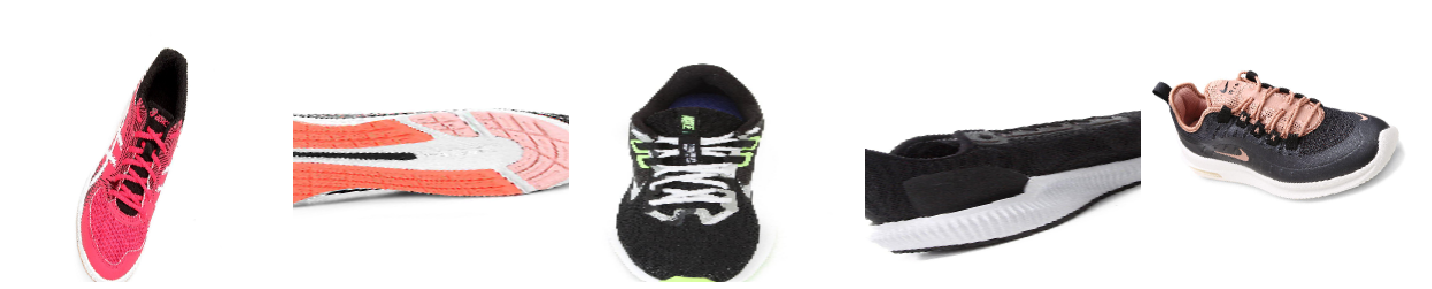

In [18]:
sample_training_images, _ = next(train_data_gen)

plot_images(sample_training_images[:5])

In [19]:
learning_rate = 0.0003

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

if(initial_epoch == 0):
    run = ''
else:
    run = '_2'
    
logdir = f"{checkpoint_path}{run}/logs/scalars/"
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                       save_best_only=True,
                                       monitor='val_acc',
                                       mode='max',
                                       save_weights_only=False),
    tf.keras.callbacks.TensorBoard(log_dir=logdir,profile_batch=0,update_freq='batch')
]

history = model.fit(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // train_data_gen.batch_size,
    epochs=initial_epoch + epochs,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // val_data_gen.batch_size,
    callbacks=callbacks,
    initial_epoch=initial_epoch
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 116 steps, validate for 15 steps
Epoch 1/100
115/116 [============================>.] - ETA: 3s - loss: 1.9273 - acc: 0.2151WARNING:tensorflow:From /home/raphael/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./brand_model/drop25_lr0001_graph_b1/assets
116/116 [==============================] - 406s 4s/step - loss: 1.9265 - acc: 0.2155 - val_loss: 1.7616 - val_acc: 0.3130
Epoch 2/100
116/116 [==============================] - 331s 3s/step - loss: 1.7569 - acc: 0.3090 - val_loss: 1.6383 - val_acc: 0.3922
Epoch 3/100
116/116 [==============================] - 333s 3s/step - loss: 1.6629 - acc: 0.3616 - val_los

116/116 [==============================] - 305s 3s/step - loss: 1.2905 - acc: 0.5334 - val_loss: 1.2002 - val_acc: 0.5745
Epoch 32/100
116/116 [==============================] - 331s 3s/step - loss: 1.2918 - acc: 0.5237 - val_loss: 1.1935 - val_acc: 0.5786
Epoch 33/100
116/116 [==============================] - 305s 3s/step - loss: 1.2952 - acc: 0.5284 - val_loss: 1.1935 - val_acc: 0.5786
Epoch 34/100
116/116 [==============================] - 329s 3s/step - loss: 1.2962 - acc: 0.5269 - val_loss: 1.1871 - val_acc: 0.5828
Epoch 35/100
116/116 [==============================] - 303s 3s/step - loss: 1.2906 - acc: 0.5286 - val_loss: 1.1826 - val_acc: 0.5828
Epoch 36/100
116/116 [==============================] - 329s 3s/step - loss: 1.2809 - acc: 0.5296 - val_loss: 1.1821 - val_acc: 0.5865
Epoch 37/100
116/116 [==============================] - 303s 3s/step - loss: 1.2759 - acc: 0.5311 - val_loss: 1.1822 - val_acc: 0.5802
Epoch 38/100
116/116 [==============================] - 303s 3s/step

116/116 [==============================] - 316s 3s/step - loss: 1.2252 - acc: 0.5530 - val_loss: 1.1082 - val_acc: 0.6130
Epoch 76/100
116/116 [==============================] - 317s 3s/step - loss: 1.2275 - acc: 0.5541 - val_loss: 1.1070 - val_acc: 0.6151
Epoch 77/100
116/116 [==============================] - 319s 3s/step - loss: 1.2257 - acc: 0.5541 - val_loss: 1.1092 - val_acc: 0.6068
Epoch 78/100
 40/116 [=========>....................] - ETA: 3:21 - loss: 1.2237 - acc: 0.5493WARNING:tensorflow:Can save best model only with val_acc available, skipping.


KeyboardInterrupt: 

In [42]:
model = tf.keras.models.load_model('./brand_model/drop25_lr0001_graph_b1')

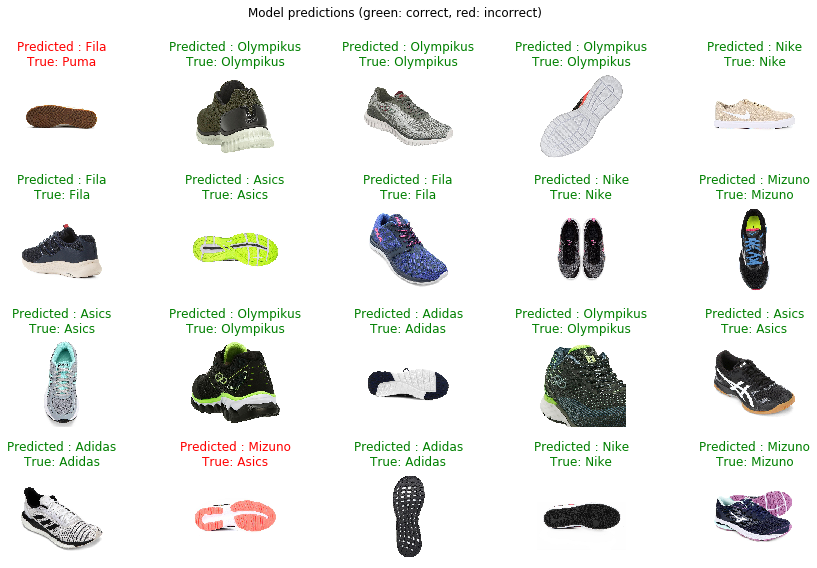

In [43]:
class_names = sorted(train_data_gen.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])

image_batch, label_batch = test_data_gen.next()

predicted_batch = model.predict(image_batch)
real_id = np.argmax(label_batch,axis=-1)
real_label_batch = class_names[real_id]
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

label_id = np.argmax(label_batch, axis=-1)

plt.figure(figsize=(15,9))
plt.subplots_adjust(hspace=0.5)
for n in range(20):
    plt.subplot(4,5,n+1)
    plt.imshow(image_batch[n])
    color = "green" if predicted_id[n] == label_id[n] else "red"
    plt.title(f"Predicted : {predicted_label_batch[n].title()}\nTrue: {real_label_batch[n].title()}",
              color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")
plt.show()

In [44]:
# Evaluation on whole val set
model.evaluate(val_data_gen)

# Evaluation on whole test set
model.evaluate(test_data_gen)

  ...
    to  
  ['...']
16/16 [==============================] - 25s 2s/step - loss: 1.1146 - acc: 0.6148
  ...
    to  
  ['...']
6/6 [==============================] - 9s 1s/step - loss: 1.0951 - acc: 0.6195


[1.0951456824938457, 0.6194825]

In [63]:
weights = model.get_weights()
model_fine = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        Dropout(drop_rate),
        tf.keras.layers.Dense(df_shoes['brand'].nunique()),
    ])
model_fine.set_weights(weights)

In [64]:
model_fine.get_layer("efficientnet-b1").trainable = True

set_trainable = False
for layer in model_fine.get_layer("efficientnet-b1").layers:
    if layer.name == 'multiply_16':
        set_trainable = True
    if set_trainable:
        model_fine.get_layer("efficientnet-b1").trainable = True
    else:
        layer.trainable = False
        
model_fine.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b1 (Model)      (None, 8, 8, 1280)        6575232   
_________________________________________________________________
global_average_pooling2d_7 ( (None, 1280)              0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 7)                 8967      
Total params: 6,584,199
Trainable params: 8,967
Non-trainable params: 6,575,232
_________________________________________________________________


In [65]:
model_fine.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

In [67]:
fine_tune_epochs = 10
total_epochs =  epochs + fine_tune_epochs
checkpoint_path = ".brand_model/b1_fine_tuned"
os.makedirs(checkpoint_path)
logdir = f"{checkpoint_path}{run}_fine_tune/logs/scalars/"
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                       save_best_only=True,
                                       monitor='val_acc',
                                       mode='max',
                                       save_weights_only=False),
    tf.keras.callbacks.TensorBoard(log_dir=logdir,profile_batch=0,update_freq='batch')
]

history = model_fine.fit(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // train_data_gen.batch_size,
    epochs=total_epochs,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // val_data_gen.batch_size,
    callbacks=callbacks,
    initial_epoch=100
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 116 steps, validate for 15 steps
Epoch 101/110
116/116 [==============================] - 336s 3s/step - loss: 1.2189 - acc: 0.5523 - val_loss: 1.1060 - val_acc: 0.6125
Epoch 102/110
116/116 [==============================] - 304s 3s/step - loss: 1.2269 - acc: 0.5524 - val_loss: 1.1063 - val_acc: 0.6120
Epoch 103/110
116/116 [==============================] - 329s 3s/step - loss: 1.2239 - acc: 0.5534 - val_loss: 1.1060 - val_acc: 0.6172
Epoch 104/110
116/116 [==============================] - 304s 3s/step - loss: 1.2170 - acc: 0.5568 - val_loss: 1.1056 - val_acc: 0.6130
Epoch 105/110
116/116 [==============================] - 304s 3s/step - loss: 1.2244 - acc: 0.5530 - val_loss: 1.1017 - val_acc: 0.6172
Epoch 106/110
116/116 [==============================] - 304s 3s/step - loss: 1.2266 - acc: 0.5497 - val_loss: 1.1016 - val_acc: 0.6109
Epoch 107/110
116/116 [==============================] - 303s 3s/step - loss: 1.2219 - acc:

KeyboardInterrupt: 

In [ ]:
model = tf.keras.models.load_model(checkpoint_path)

# Evaluation on whole val set
model.evaluate(val_data_gen)

# Evaluation on whole test set
model.evaluate(test_data_gen)